In [1]:
import numpy as np 

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict

import glob, os
import pickle

%matplotlib inline


In [2]:
def joint_plot(sub_diff_df, x="k", y="G", label=None, color="blue", limx=None, limy=None, 
                sct_lw=0.5, sct_size=50, sct_alpha=1.0, legends=None, label_x="", label_y="", 
                scale_density=[[1, 1], [1, 1]], bw_scale_xy=[[1, 1], [1, 1]],
                save_dir=None, more_info=None,axh=None,avh=None,sct_st=None):
    
    fig = plt.figure(figsize=(8, 8))
    grid = plt.GridSpec(1, 1)
    
    if limx is None:
        scaler_x = MinMaxScaler().fit(sub_diff_df[x].values[:, None])
        limx = scaler_x.inverse_transform(np.array([-0.1, 1.05])[:, None]).ravel()
    if limy is None:
        scaler_y = MinMaxScaler().fit(sub_diff_df[y].values[:, None])
        limy = scaler_y.inverse_transform(np.array([-0.1, 1.05])[:, None]).ravel()
    if label is not None:
        assert len(np.unique(sub_diff_df[label]))<=len(color)
        
    ax = fig.add_subplot(grid[0, 0])
    if label is None:
        ax.scatter(*sub_diff_df[[x, y]].values.T, s=sct_size, c=color, alpha=sct_alpha, 
                    edgecolor="white", linewidths=sct_lw, zorder=12)
        sns.kdeplot(*sub_diff_df[[x, y]].values.T, color=color, alpha=0.4)
    else:
        for li in sorted(set(sub_diff_df[label].values)):
            sub_df = sub_diff_df[sub_diff_df[label]==li]
            ax.scatter(*sub_df[[x, y]].values.T, s=sct_size, c=color[li], alpha=sct_alpha, 
                        edgecolor="white", linewidths=sct_lw, zorder=12, 
                        label=legends[li] if legends is not None else None,
                         marker=sct_st[li])
           
            sns.kdeplot(x=sub_df[[x, y]].values.T[0],y=sub_df[[x, y]].values.T[1], color=color[li], alpha=0.4)
        
        if axh:
            ax.axhline(y=axh,ls='-.',c='black',linewidth=1.0)
        if avh:
            ax.axvline(x=avh,ls='-.',c='black',linewidth=1.0)

        if axh and avh:
            ax.scatter(avh,axh,s=sct_size+50,zorder=20,marker='o',c='black', 
                       edgecolor="white",linewidths=sct_lw,label=legends[-1])
    
        if legends is not None:
            plt.legend(loc="best", fontsize=22, frameon=True,shadow=False,
                       borderpad=0.2,handletextpad=0.05,borderaxespad=0.2,handlelength=1.5)
    

    ax.set_xlim(limx)
    ax.set_ylim(limy)
    ax.set_xlabel(label_x, fontsize=26,labelpad=10)
    ax.set_ylabel(label_y, fontsize=26,labelpad=10)
    ax.tick_params("both", direction='out', length=5, width=2, labelsize=20)

    grid.tight_layout(fig,pad=0.05)
    if save_dir is not None:
        makedirs(save_dir)
        more_info = "" if more_info is None else "_{}".format(more_info)
        save_name = "{0}/joint_plot{1}.pdf".format(save_dir, more_info)
        plt.savefig(save_name)
        print("Saved at: "+ save_name)
    else:
        plt.show()

In [3]:
smfe_data = np.load('../material-dl/processed_data/smfe/smfe_data_energy.npy',allow_pickle=True)
energy = np.array([x['Properties']['f_en'] for x in smfe_data],np.float32)

In [4]:
energy_pre = pickle.load(open('trained_models/model_smfe_f_en/energy_pre_f_en.pickle','rb'))
energy_pre_opt = []
for x in energy_pre:
    for e in x:
        energy_pre_opt.append(e/1000)
energy_pre_opt = np.array(energy_pre_opt)

attention_f_opt = pickle.load(open('trained_models/model_smfe_f_en/ga_scores_f_en.pickle','rb'))


In [5]:
r2_score(energy_pre_opt,energy), mean_absolute_error(energy_pre_opt,energy)

(0.9964014842140316, 0.0026463848067993095)

In [6]:
statis = []
types =[]
energy = []

statis_at_en = defaultdict(list)
statis_at_en['Fe'] = [[1.0,0.07,0]]

X = ['Al','Ti','Cu','Co','Zn','Mo','Ga']

for idx, d in enumerate(smfe_data):
    mix = set(d['Atoms'])
    if len(mix) == 3:
        other_at = defaultdict(list)
        fe_at = []
        
        for k in range(len(d['Atoms'])):
            for sub in X:
                if d['Atoms'][k] == sub:
                    other_at[sub].append(round(attention_f_opt[idx][k][0],3))
            else:
                fe_at.append(round(attention_f_opt[idx][k][0],3))
        
        min_fe = np.min(fe_at)
        
        ener = float(d['Properties']['f_en'])
        for sub in other_at:
            for i, at in enumerate(other_at[sub]):
                types = 1
                if sub in ['Mo','Zn','Cu']:
                    types = 0
                    
                statis_at_en[sub].append([at/min_fe,ener,types])


In [7]:
sub = 'X'
data = np.concatenate([statis_at_en[x] for x in statis_at_en])

# data = statis_at_en['Sm']
att_en = pd.DataFrame(data=data,columns=['Attention ratio ' + sub +'/Fe','ΔE','Types'])

att_en['Types'] = att_en['Types'].astype('int8')

In [8]:
colors = ['blue','red','green']
markers= ['o','o','s']

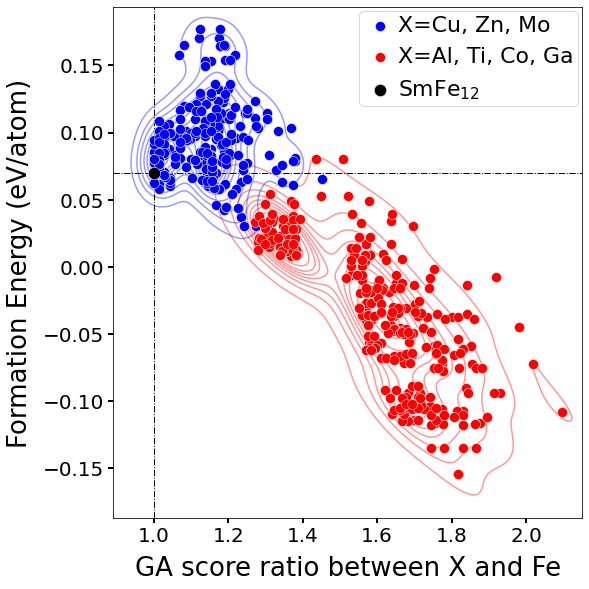

In [9]:
joint_plot(att_en, x="Attention ratio X/Fe", y="ΔE", label="Types", color=colors, limx=None, limy=None,  
            sct_lw=0.5, sct_size=100, sct_alpha=1.0, legends=['X=Cu, Zn, Mo','X=Al, Ti, Co, Ga','SmFe'r'$_{12}$'], 
           label_x="GA score ratio between X and Fe", label_y="Formation Energy (eV/atom)",
           axh=statis_at_en['Fe'][0][1],avh=statis_at_en['Fe'][0][0],sct_st=markers,more_info='SmFe12')